# Rainbow implementation.

Original papers:
- https://arxiv.org/pdf/1312.5602.pdf
- https://arxiv.org/pdf/1710.02298.pdf

In [2]:
import random
import numpy as np
import torch
import utils
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ENV_NAME = "BreakoutNoFrameskip-v4"

## Preprocessing

Let's see what observations look like.

A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


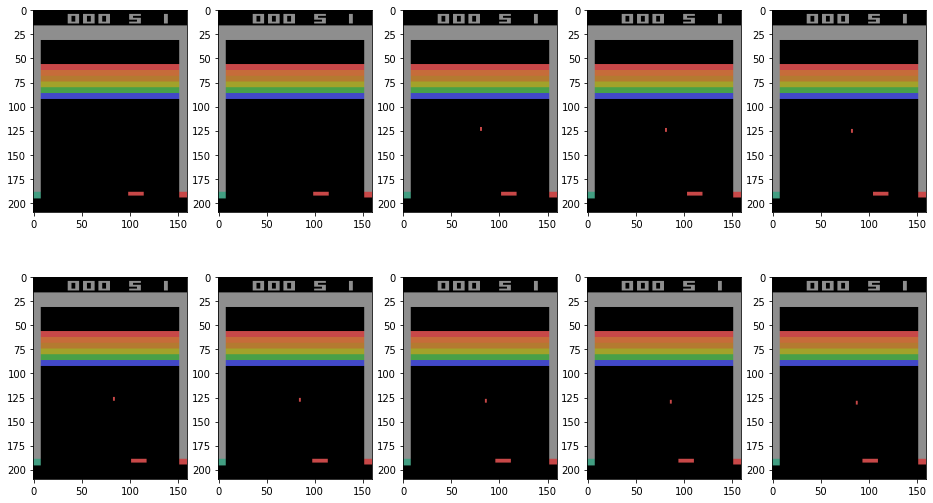

In [5]:
env = gym.make(ENV_NAME)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render('rgb_array'))
        env.step(env.action_space.sample())
plt.show()

### Processing game image 

Transform the images
* Resizing to a smaller shape, 64x64
* Converting to grayscale
* Cropping irrelevant image parts (top, bottom and edges)

In [7]:
from gym.core import ObservationWrapper
from gym.spaces import Box
import cv2

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        ObservationWrapper.__init__(self, env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        return rgb @ channel_weights


    def observation(self, img):
        """what happens to each observation"""

        grey_img = self._to_gray_scale(img)
        crop = grey_img[30:200,8:152].reshape(170,144,1)
        resized = cv2.resize(crop, self.img_size[1:]).reshape(self.img_size).astype('float32')
        resized /= 255
        
        return resized

Formal tests seem fine. Here's an example of what you'll get.


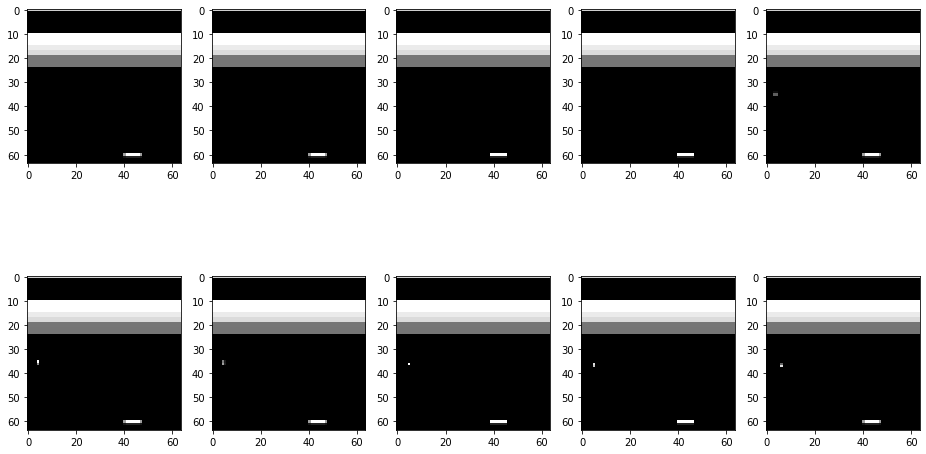

In [8]:
n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _ = env.step(env.action_space.sample())
plt.show()

### Wrapping.

In [9]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id

    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

### Frame buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so it must be able to measure object's velocity. We introduce a buffer that stores 4 last images.

In [11]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME)  # create raw env
    if seed is not None:
        env.seed(seed)
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape

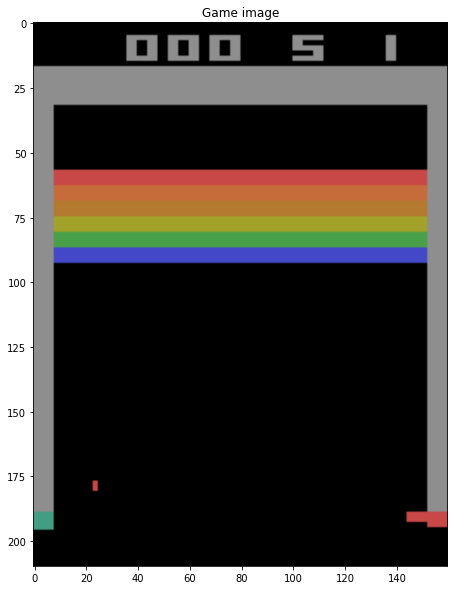

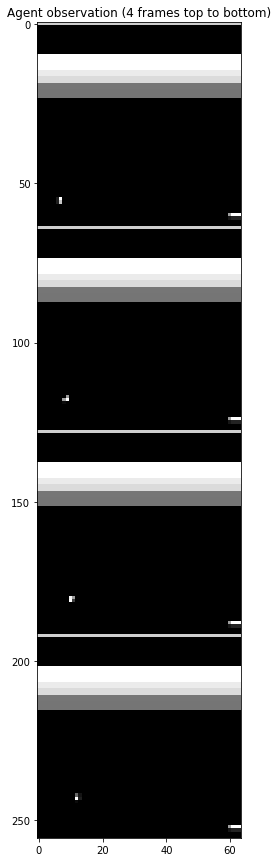

In [12]:
for _ in range(12):
    obs, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

## DQN as it is

### Building a network

Architecture:
- 4-frame buffer
- Conv: in_layers=4, out_layers=16, kernel=3, stride=2
- ReLU
- Conv: in_layers=16, out_layers=32, kernel=3, stride=2
- ReLU
- Conv: in_layers=32, out_layers=64, kernel=3, stride=2
- ReLU
- Flatten
- Dense layer: in=7*7*64, out=256
- Two heads: Q-values and Advatage

**Dueling network:** https://arxiv.org/pdf/1511.06581.pdf
$$Q_{\theta}(s, a) = V_{\eta}(f_{\xi}(s)) + A_{\psi}(f_{\xi}(s), a) - \frac{\sum_{a'}A_{\psi}(f_{\xi}(s), a')}{N_{actions}},$$
where $\xi$, $\eta$, and $\psi$ are, respectively, the parameters of the
shared encoder $f_ξ$ , of the value stream $V_\eta$ , and of the advantage stream $A_\psi$; and $\theta = \{\xi, \eta, \psi\}$ is their concatenation.

In [13]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cpu')

In [14]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

In [15]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        self.feature = nn.Sequential(
            nn.Conv2d(4, 16, 3, 2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(7*7*64, 256),
            nn.ReLU()
        )
        
        self.value = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
        

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        
        features = self.feature(state_t)
        value = self.value(features)
        advantage = self.advantage(features)
        qvalues = value + advantage - advantage.mean(dim = 1)

        assert qvalues.requires_grad, "qvalues must be a torch tensor with grad"
        assert (
            len(qvalues.shape) == 2 and 
            qvalues.shape[0] == state_t.shape[0] and 
            qvalues.shape[1] == n_actions
        )

        return qvalues

    def get_qvalues(self, states):
        """
        like forward, but works on numpy arrays, not tensors
        """
        
        b = states
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """
        pick actions given qvalues. Uses epsilon-greedy exploration strategy.
        """
        
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)

        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [16]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

### Experience replay
With priority: https://arxiv.org/pdf/1511.05952.pdf

In [18]:
import random


class ReplayBuffer(object):
    def __init__(self, size, exp_alpha=0.6):
        """
        Create Replay buffer with priorities.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size
        self._alpha = exp_alpha
        self._priority = np.zeros((size,))
        self._max_priority = 1.0
        
        self._next_index = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        _storage will not exceed _maxsize. 
        FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)

        if len(self) < self._maxsize:
            self._storage.append(data)
        else:
            self._storage[self._next_index] = data
        
        self._priority[self._next_index] = self._max_priority
        self._next_index = (self._next_index + 1) % self._maxsize
        
    def sample(self, batch_size, exp_beta=0.4):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        if len(self) == self._maxsize:
            probs = self._priority ** self._alpha
        else:
            probs = self._priority[:self._next_index] ** self._alpha
        probs /= sum(probs)
        
        idxes = np.random.choice(len(self), size=batch_size, p=probs)
        
        weights = (len(self) * probs[idxes]) ** (-exp_beta)
        weights /= weights.max()
        
        result = [self._storage[index] for index in idxes]
        
        self._last_indexes = idxes
        self._weights = weights
        
        return tuple(np.array([item[i] for item in result]) for i in range(5))
    
    def update_priority(self, loss):
        np_loss = loss.detach().numpy()
        new_priority = np_loss * self._weights
        for index, prior in zip(self._last_indexes, new_priority):
            self._priority[index] = prior
        self._max_priority = self._priority.max()

In [20]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n_steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has done=False when passed to this function.

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above

    for t in range(n_steps):
        # get agent to pick action given state s
        a = agent.sample_actions(agent.get_qvalues([s]))[0]
        next_s, r, done, _ = env.step(a)

        # store current <s,a,r,s'> transition in buffer
        exp_replay.add(s, a, r, next_s, done)

        s = next_s
        sum_rewards += r
        if done:
            s = env.reset()

    return sum_rewards, s

### Target networks

"Target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$

In [22]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)

target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Loss
Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

With Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Where
* $Q_{target}(s',a')$ denotes Q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.

**Double DQN**: https://arxiv.org/pdf/1509.06461.pdf

$$ Q_{reference}(s,a) = r(s, a) + \gamma \cdot
Q_{target}(s',argmax_{a'}Q_\theta(s', a')) $$

In [23]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]

    predicted_next_qvalues = target_network(next_states)  # shape: [batch_size, n_actions]
    
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]

    next_q_values = agent(next_states)  # shape: [batch_size, n_actions], Q_\theta(s', a')
    next_state_values = predicted_next_qvalues.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)

    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

    loss = torch.mean((predicted_qvalues_for_actions - target_qvalues_for_actions.detach()) ** 2)

    return loss

## Main loop

In [25]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [26]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [27]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quite enough. $10^2$ will probably fail learning.

In [28]:
REPLAY_BUFFER_SIZE = 10**4
N_STEPS = 100

exp_replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
for i in range(REPLAY_BUFFER_SIZE // N_STEPS):
    play_and_record(state, agent, env, exp_replay, n_steps=N_STEPS)
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replay))

10000


In [29]:
timesteps_per_epoch = 1
batch_size = 16
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 1
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 5000
eval_freq = 5000

max_grad_norm = 50

n_lives = 5

In [30]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

In [31]:
import time

def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

buffer size = 10000, epsilon = 0.10000, beta = 1.00000


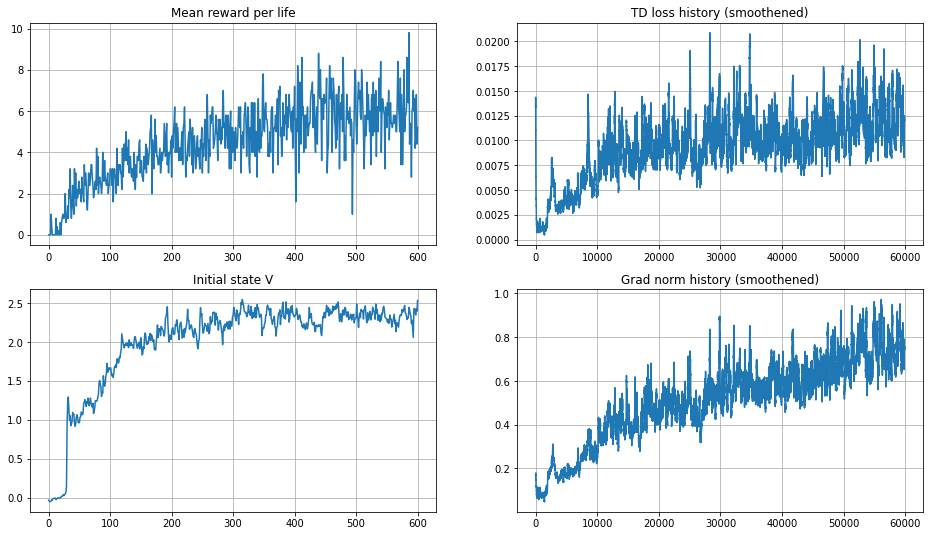

100%|██████████████████████████████| 3000001/3000001 [25:37:50<00:00, 32.51it/s]


In [32]:
state = env.reset()
beta = 0.4
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not utils.is_enough_ram():
            print('less that 100 Mb RAM available, freezing')
            print('make sure everything is ok and use KeyboardInterrupt to continue')
            wait_for_keyboard_interrupt()

        agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # play
        _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

        # train
        s_, a_, r_, next_s_, done_ = exp_replay.sample(batch_size, beta)

        loss = compute_td_loss(s_, a_, r_, next_s_, done_, agent, target_network)

        loss.backward()
        
        exp_replay.update_priority(loss)
        
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()

        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())
            grad_norm_history.append(grad_norm)

        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            target_network.load_state_dict(agent.state_dict())

        if step % eval_freq == 0:
            if beta < 1.0:
                beta += 1e-3
            
            mean_rw_history.append(evaluate(
                make_env(clip_rewards=True, seed=step), agent, n_games=3 * n_lives, greedy=True)
            )
            initial_state_q_values = agent.get_qvalues(
                [make_env(seed=step).reset()]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f, beta = %.5f" %
                (len(exp_replay), agent.epsilon, beta))

            plt.figure(figsize=[16, 9])

            plt.subplot(2, 2, 1)
            plt.title("Mean reward per life")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(2, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(utils.smoothen(td_loss_history))
            plt.grid()

            plt.subplot(2, 2, 3)
            plt.title("Initial state V")
            plt.plot(initial_state_v_history)
            plt.grid()

            plt.subplot(2, 2, 4)
            plt.title("Grad norm history (smoothened)")
            plt.plot(utils.smoothen(grad_norm_history))
            plt.grid()

            plt.show()

In [79]:
torch.save({
            'epoch': 30000001,
            'model_state_dict': agent.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss,
            'buffer size': 10000,
            'epsilon': 0.10000
            }, './checkpoint_3')

## How to interpret plots:

This aint no supervised learning so don't expect anything to improve monotonously. 
* **TD loss** is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* **grad norm** just shows the intensivity of training. Not ok is growing to values of about 100 (or maybe even 50) though it depends on network architecture.
* **mean reward** is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...). 
 * In basic q-learning implementation it takes about 40k steps to "warm up" agent before it starts to get better.
* **Initial state V** is the expected discounted reward for episode in the oppinion of the agent. It should behave more smoothly than **mean reward**. It should get higher over time but sometimes can experience drawdowns because of the agaent's overestimates.
* **buffer size** - this one is simple. It should go up and cap at max size.
* **epsilon** - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - it means you need to increase epsilon. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Smoothing of plots is done with a gaussian kernel

### Video

In [42]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos0", force=True) as env_monitor:
    sessions = [evaluate(env_monitor, agent, n_games=n_lives, greedy=True) for _ in range(10)]

In [46]:
from pathlib import Path
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos0').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-4]  # You can also try other indices
data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

**Замечание:** Нейросеть выучила отводить тележку до конца влево после каждого отбития. Это выглядит не самой лучшей стратегией, но стабилизирует политику.

## Bonus analysis

In [47]:
eval_env = make_env(clip_rewards=False)
record = utils.play_and_log_episode(eval_env, agent)
print('total reward for life:', np.sum(record['rewards']))
for key in record:
    print(key)

total reward for life: 12.0
states
v_mc
v_agent
q_spreads
td_errors
rewards
episode_finished


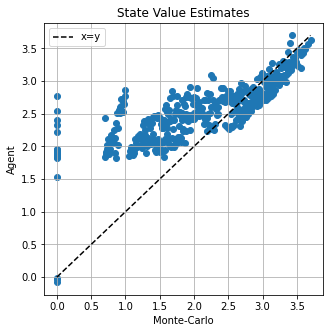

In [48]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(record['v_mc'], record['v_agent'])
ax.plot(sorted(record['v_mc']), sorted(record['v_mc']),
       'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('State Value Estimates')
ax.set_xlabel('Monte-Carlo')
ax.set_ylabel('Agent')

plt.show()

$\hat V_{Monte-Carlo}(s_t) = \sum_{\tau=0}^{episode~end} \gamma^{\tau-t}r_t$

**Conclution:** Bias is significant, greater with low values of Monte-Carlo.

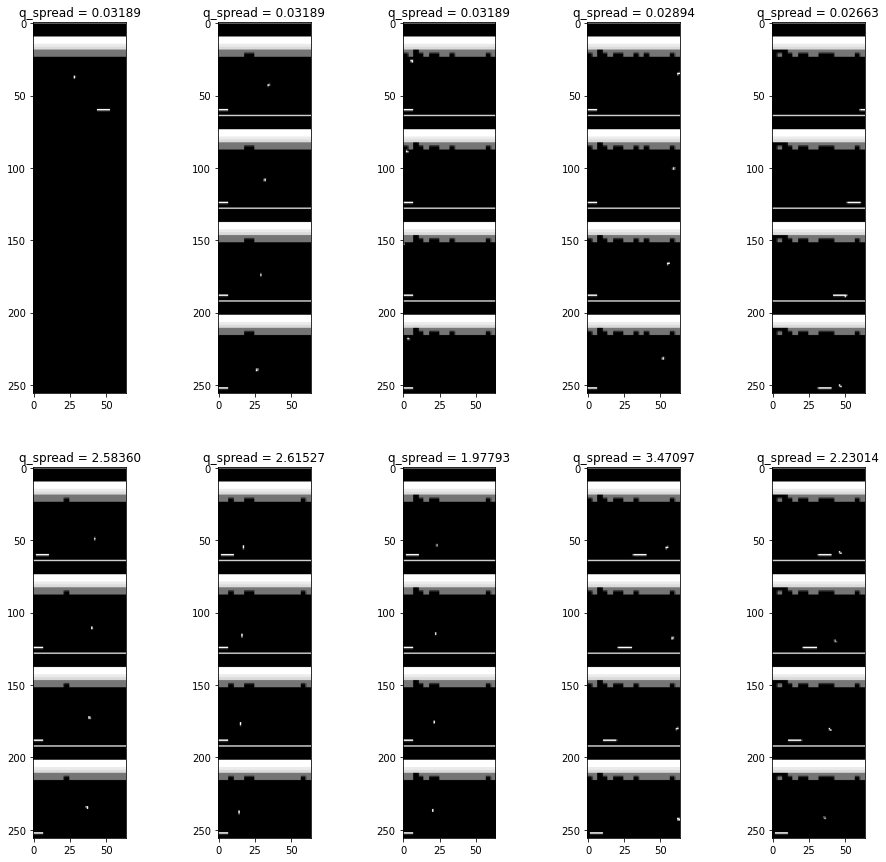

In [70]:
from utils import play_and_log_episode, img_by_obs

fig = plt.figure(figsize=(16, 15))
num_states = 5
eval_env = make_env(clip_rewards=False)
record = utils.play_and_log_episode(eval_env, agent)
for i in range(num_states):
    first_index = int(i * len(record['q_spreads']) / num_states)
    last_index = int((i + 1) * len(record['q_spreads']) / num_states)
    state_index_with_min_spread = record['q_spreads'][first_index:last_index].argmin()
    state_index_with_max_spread = record['q_spreads'][first_index:last_index].argmax()
    ax = fig.add_subplot(2, num_states, i + 1)
    ax.set_title('q_spread = {:.5f}'.format(record["q_spreads"][first_index + state_index_with_min_spread]))
    ax.imshow(utils.img_by_obs(record['states'][first_index + state_index_with_min_spread], state_shape), cmap='gray')
    ax = fig.add_subplot(2, num_states, i + num_states + 1)
    ax.set_title('q_spread = {:.5f}'.format(record["q_spreads"][first_index + state_index_with_max_spread]))
    ax.imshow(utils.img_by_obs(record['states'][first_index + state_index_with_max_spread], state_shape), cmap='gray')

**Выводы:** Наименьший разброс (верхняя строка) возникает, когда шарик находится достаточно далеко и тележка его не должна отбивать в ближайшие фреймы, поэтому от ее движения ситуация особо не изменится. Наибольший разброс (нижняя строка) отвечает за моменты, когда шарик почти достиг нижней линии и тележка находится возле него. От ее движения в данный момент зависит, отобьет она или нет.

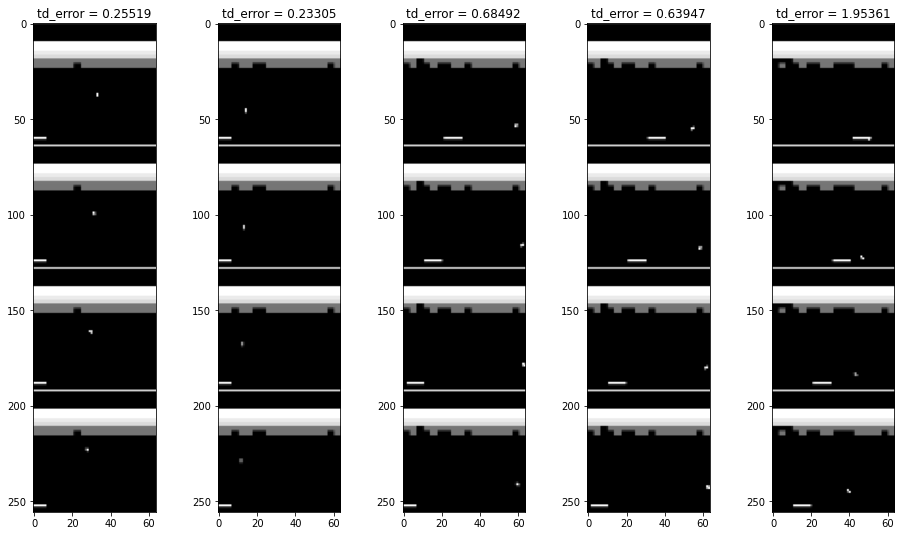

In [77]:
fig = plt.figure(figsize=(16, 9))
num_states = 5
for i in range(num_states):
    first_index = int(i * len(record['td_errors']) / num_states)
    last_index = int((i + 1) * len(record['td_errors']) / num_states)
    state_index_with_max_error = record['td_errors'][first_index:last_index].argmax()
    ax = fig.add_subplot(1, num_states, i + 1)
    ax.set_title('td_error = {:.5f}'.format(record["td_errors"][first_index + state_index_with_max_error]))
    ax.imshow(utils.img_by_obs(record['states'][first_index + state_index_with_max_error], state_shape), cmap='gray')

**Вывод:** Максимальная ошибка возникает, когда тележка далеко от шарика и не успевает отбить

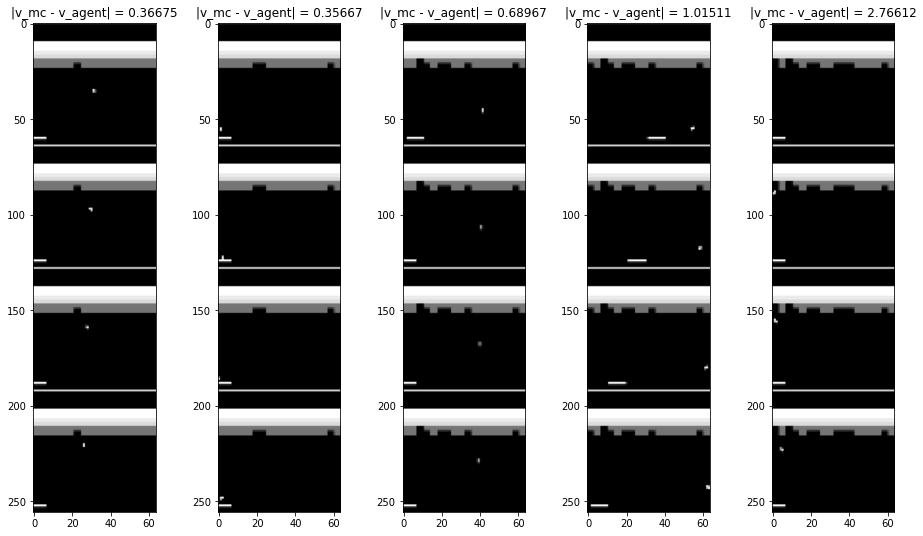

In [78]:
fig = plt.figure(figsize=(16, 9))
num_states = 5
for i in range(num_states):
    first_index = int(i * len(record['v_mc']) / num_states)
    last_index = int((i + 1) * len(record['v_mc']) / num_states)
    state_index_with_max_diff = np.abs(record['v_mc'] - record['v_agent'])[first_index:last_index].argmax()
    ax = fig.add_subplot(1, num_states, i + 1)
    ax.set_title('|v_mc - v_agent| = {:.5f}'.format(np.abs(record['v_mc'] - record['v_agent'])[first_index + state_index_with_max_diff]))
    ax.imshow(utils.img_by_obs(record['states'][first_index + state_index_with_max_diff], state_shape), cmap='gray')